# Цель работы: изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

Постановка задачи:

Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

Набор данных относится к клиентам оптового дистрибьютора. Он включает годовые расходы в денежных единицах (млн долл.) на различные категории товаров

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('Wholesale customers data.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
df.info()
df.isnull().sum()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


1. Channel (Horeca / Retail)
Тип: номинальная, 2 категории (1, 2)
Всего наблюдений: 440 (100% валидных)
Несоответствий: 0, пропущенных: 0
Среднее: 1.32, стандартное отклонение: 0.47
Минимум: 1, максимум: 2
Квантиль: 25% = 1, 50% = 2, 75% = 2

2. Region (Lisbon / Oporto / Other)
Тип: номинальная, 3 категории (1, 2, 3)
Всего наблюдений: 440 (100% валидных)
Несоответствий: 0, пропущенных: 0
Среднее: 2.54, стандартное отклонение: 0.77
Минимум: 2, максимум: 3
Квантиль: 25% = 3, 50% = 3, 75% = 3

3. Fresh (расходы на свежие продукты, m.u.)
Тип: количественная, непрерывная
Всего наблюдений: 440 (100% валидных)
Среднее: 12 000, стандартное отклонение: 12 600
Минимум: 3 136, максимум: 112 151
Квантиль: 25% = 8 533, 50% = 16 900, 75% = 112 000
Распределение сильно скошено вправо, есть крупные выбросы

4. Milk (расходы на молочные продукты, m.u.)
Тип: количественная, непрерывная
Всего наблюдений: 440
Среднее: 5 800, стандартное отклонение: 7 370
Минимум: 1 534, максимум: 73 498
Квантиль: 25% = 3 634, 50% = 7 209, 75% = 73 500
Присутствуют значительные выбросы

5. Grocery (расходы на бакалею, m.u.)
Тип: количественная, непрерывная
Всего наблюдений: 440
Среднее: 7 950, стандартное отклонение: 9 490
Минимум: 2 155, максимум: 92 780
Квантиль: 25% = 4 757, 50% = 10 700, 75% = 92 800

6. Frozen (расходы на замороженные продукты, m.u.)
Тип: количественная, непрерывная
Всего наблюдений: 440
Среднее: 3 070, стандартное отклонение: 4 850
Минимум: 744, максимум: 60 869
Квантиль: 25% = 1 535, 50% = 3 570, 75% = 60 900

7. Detergents_Paper (расходы на моющие и бумажные продукты, m.u.)
Тип: количественная, непрерывная
Всего наблюдений: 440
Среднее: 2 880, стандартное отклонение: 4 760

Минимум: 257, максимум: 40 827
Квантиль: 25% = 820, 50% = 3 961, 75% = 40 800

8. Delicassen (расходы на деликатесы, m.u.)
Тип: количественная, непрерывная
Всего наблюдений: 440
Среднее: 1 520, стандартное отклонение: 2 820
Минимум: 409, максимум: 47 943
Квантиль: 25% = 967, 50% = 1 824, 75% = 47 900

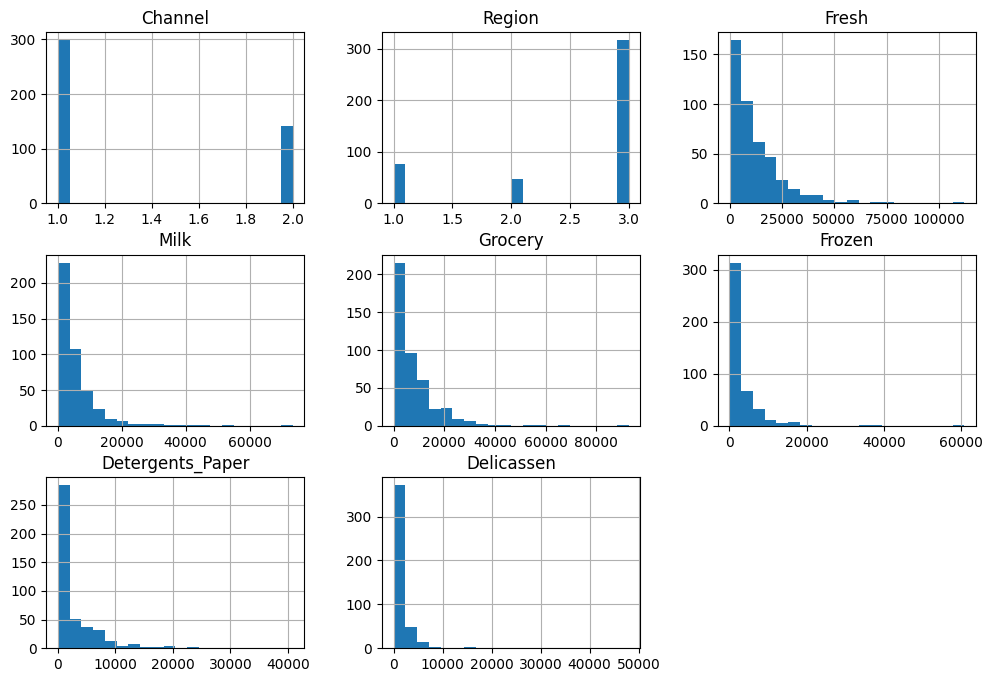

In [5]:
df.hist(bins=20, figsize=(12,8))
plt.show()
